In [1]:
import mpramnist
from mpramnist.malinoisdataset import MalinoisDataset
from mpramnist.vikramdataset import VikramDataset
from mpramnist import transforms as t
from mpramnist import target_transforms as t_t
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Initiate some parameters

In [2]:
left_flank = MalinoisDataset.LEFT_FLANK
right_flank = MalinoisDataset.RIGHT_FLANK
BATCH_SIZE = 1076
NUM_WORKERS = 103

# default parametes
activity_columns = ['HepG2','SKNSH', "K562"]
stderr = ['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']
seq = "sequence"
stderr_threshold = 1.0,
std_multiple_cut = 6.0,
up_cutoff_move = 3.0,
duplication_cutoff = 0.5

# You wanna test original parametes?

So use this code

In [3]:
train_dataset = MalinoisDataset(split = "train",
                                filtration = "original", # use "original for author's parameters"
                                duplication_cutoff = 0.5,
                                use_original_reverse_complement = True # this parameter paddes sequences and does rev comp
                               )

val_dataset = MalinoisDataset(split = "val",
                              filtration = "original") 

test_dataset = MalinoisDataset(split = "test",
                              filtration = "original")

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

# Use your own parameters

Use this part 

In [3]:
# preprocessing
train_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Reverse(0.5),
    t.Seq2Tensor()
])
val_test_transform = t.Compose([
    t.AddFlanks(left_flank, right_flank),
    t.CenterCrop(600),
    t.Seq2Tensor()
])

# load the data
train_dataset = MalinoisDataset( 
                              split = "train", 
                              transform = train_transform,
                              filtration = "own",
                              duplication_cutoff = 0.5) 
val_dataset = MalinoisDataset(
                              split = "val",
                              filtration = "own",
                              transform = val_test_transform) 
test_dataset = MalinoisDataset(
                              split = "test", 
                              filtration = "own",
                              transform = val_test_transform)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = NUM_WORKERS)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = NUM_WORKERS)

# Some dataset Info

In [4]:
print(train_dataset)
print("="*50)
print(val_dataset)
print("="*50)
print(test_dataset)

Dataset MalinoisDataset of size 932088 (MpraDaraset)
    Number of datapoints: 932088
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used split fold: ['1', '2', '3', '4', '5', '6', '8', '9', '10', '11', '12', '14', '15', '16', '17', '18', '20', '22', 'Y']
    Scalar features: {}
    Vector features: {}
    Cell types: ['HepG2', 'K562', 'SKNSH']
    Сell type used: ['K562_log2FC', 'HepG2_log2FC', 'SKNSH_log2FC']
    Target columns that can be used: {'K562_log2FC', 'HepG2_log2FC', 'SKNSH_log2FC'}
    Number of channels: 4
    Sequence size: 600
    Number of samples: {'train': 668946, 'val': 62406, 'test': 66712}
    Description: MalinoisDataset is based on 
Dataset MalinoisDataset of size 58809 (MpraDaraset)
    Number of datapoints: 58809
    Default split folds: {'train': '1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 20, 22, Y', 'val': '19, 21, X', 'test': '7, 13'}
    Used spl

# Define loss criterion from Malinois

In [5]:
class L1KLmixed(nn.Module):
    
    def __init__(self, reduction='mean', alpha=1.0, beta=1.0):
        super().__init__()
        
        self.reduction = reduction
        self.alpha = alpha
        self.beta  = beta
        
        self.MSE = nn.L1Loss(reduction=reduction.replace('batch',''))
        self.KL  = nn.KLDivLoss(reduction=reduction, log_target=True)
        
    def forward(self, preds, targets):
        preds_log_prob  = preds   - torch.logsumexp(preds, dim=-1, keepdim=True)
        target_log_prob = targets - torch.logsumexp(targets, dim=-1, keepdim=True)
        
        MSE_loss = self.MSE(preds, targets)
        KL_loss  = self.KL(preds_log_prob, target_log_prob)
        
        combined_loss = MSE_loss.mul(self.alpha) + \
                        KL_loss.mul(self.beta)
        
        return combined_loss.div(self.alpha+self.beta)

# Define Simple model

In [41]:
class Simple_Net(nn.Module):
    
    def __init__(self, output_dim = 3, seq_len = 600, in_ch = 4, block_sizes=[16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]
, kernel_size=7):
        
        super().__init__()
        self.seq_len = seq_len
        self.in_ch = in_ch
        self.out_ch = output_dim
        out_ch = 64
        nn_blocks = []
      
        for in_bs, out_bs in zip([in_ch] + block_sizes, block_sizes):
            
            block = nn.Sequential(
                nn.Conv1d(in_bs, out_bs, kernel_size=kernel_size, padding=1),
                nn.SiLU(),
                nn.BatchNorm1d(out_bs)
            )
            nn_blocks.append(block)
            
        self.conv_net = nn.Sequential(
            *nn_blocks,
            nn.Flatten(),
            nn.Linear(block_sizes[-1] * (seq_len + len(block_sizes)*(3-kernel_size)), out_ch),
        )
        self.head = nn.Sequential(nn.Linear(out_ch, out_ch),
                                   nn.BatchNorm1d(out_ch),
                                   nn.SiLU(),
                                   nn.Linear(out_ch, self.out_ch))

    def forward(self, x):
       
        out = self.conv_net(x)
        out = self.head(out)
        
        return out
        

# Define metrics and SeqModel

In [42]:
import pytorch_lightning as L

from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import TQDMProgressBar
from torchmetrics import PearsonCorrCoef
class Seq1Model(L.LightningModule):
    
    def __init__(self, out_ch, lr=3e-4):
        super().__init__()
        self.model = Simple_Net(output_dim = out_ch)
        #self.model = Basset_Net(output_dim = out_ch)
        #self.loss = nn.MSELoss() 
        self.loss = L1KLmixed(beta=5.0, reduction='mean')
        self.lr = lr
        self.pearson = PearsonCorrCoef()
        self.val_loss = []
        self.val_pears = []
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_nb):
        X, y = batch
        y_hat = self.model(X)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True,  on_step=True, on_epoch=True, logger = True)
        
        lr = self.optimizers().param_groups[0]['lr']  # Get current learning rate
        self.log('learning_rate', lr, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.val_loss.append(loss)

        corr = self.pearson(y_hat[:,0], y[:,0])
        self.val_pears.append(corr)
        self.log("val_pearson", corr, on_epoch=True, prog_bar=True, on_step = False)
        
    def on_validation_epoch_end(self):

        val_loss = torch.stack(self.val_loss, dim = 0).mean()
        val_pears = torch.stack(self.val_pears, dim = 0).mean()
        
        res_str = '|' + ' {}: {:.5f} |'.format("current_epoch", self.current_epoch) 
        res_str += ' {}: {:.5f} |'.format("val_loss", val_loss)
        res_str += ' {}: {:.5f} |'.format("val_pearson", val_pears)
        border = '-'*len(res_str)
        print("\n".join(['',border, res_str, border,'']))
        self.val_loss.clear()
        self.val_pears.clear()
        return None
        
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        corr = self.pearson(y_hat[:,0], y[:,0])
        self.log("test_pearson", 
                 corr ,
                 on_epoch=True,
                 prog_bar=True,
                 on_step=False,)
        

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x, _ = batch
        else:
            x = batch
        return self(x)

    def configure_optimizers(self):
        
        self.optimizer = torch.optim.AdamW(self.parameters(),
                                               lr=self.lr,
                                               weight_decay = 0.01)
        '''
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          betas = (0.8661062881299633,0.879223105336538),
                                          weight_decay = 0.0003438210249762151,
                                          lr = self.lr,
                                          amsgrad = True)
        '''
        
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer, # type: ignore
                                                        max_lr=self.lr,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "frequency": 1,
                    "name": "cycle_lr"
            }
            
        '''
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer = self.optimizer,
                                                                            T_0 = 4096,
                                                                            T_mult=1,
                                                                            eta_min=0.0,
                                                                            last_epoch=-1)
        lr_scheduler_config = {
                    "scheduler": lr_scheduler,
                    "interval": "step",
                    "name": 'learning_rate'
            }
            
            '''
        return [self.optimizer], [lr_scheduler_config]
        
        #return self.optimizer

# LR-finder

In [43]:
from torch_lr_finder import LRFinder
import matplotlib.pyplot as plt

model = Simple_Net(output_dim = 3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay = 0.01,)
'''
optimizer = torch.optim.AdamW(model.parameters(),
                                          betas = (0.8661062881299633,0.879223105336538),
                                          weight_decay = 0.0003438210249762151,
                                          lr = 1e-7,
                                          amsgrad = True)'''
criterion = L1KLmixed(beta=5.0, reduction='mean')

In [44]:
model

Simple_Net(
  (conv_net): Sequential(
    (0): Sequential(
      (0): Conv1d(4, 16, kernel_size=(7,), stride=(1,), padding=(1,))
      (1): SiLU()
      (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv1d(16, 24, kernel_size=(7,), stride=(1,), padding=(1,))
      (1): SiLU()
      (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv1d(24, 32, kernel_size=(7,), stride=(1,), padding=(1,))
      (1): SiLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Conv1d(32, 40, kernel_size=(7,), stride=(1,), padding=(1,))
      (1): SiLU()
      (2): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (4): Sequential(
      (0): Conv1d(40, 48, kernel_size=(7,), stride=(1,), padding=(1,))
      (1): SiLU()
      (2): BatchNorm1d(48

In [45]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")

In [46]:
lr_finder.range_test(train_loader, start_lr=1e-7, end_lr=10, num_iter=100)

 89%|████████████████████████████████████████████████████████████████████████▉         | 89/100 [00:10<00:01,  8.22it/s]


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 8.50E-03


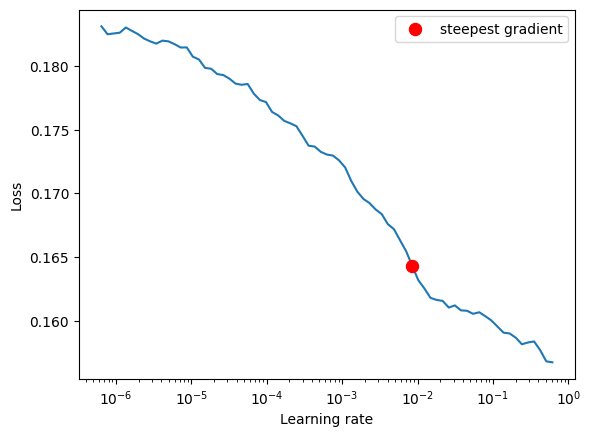

In [47]:
lr_finder.plot()  
plt.show()

# Start train

In [48]:
seq_model = Seq1Model(out_ch=len(train_dataset[0][1]), lr = 8.5e-3)

logger = pl_loggers.TensorBoardLogger("./logs_search_architecture", name = "Simple_with_OneCyclelr_NewArch[16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96]_L1KLmixed_lr8.5e-3")

# Initialize a trainer
trainer = L.Trainer(
    accelerator="gpu",
    devices=[0],
    max_epochs=25,
    gradient_clip_val=1,
    precision='16-mixed', 
    enable_progress_bar = False,
    #callbacks=[TQDMProgressBar(refresh_rate=55)]
    logger = logger
)

# Train the model
trainer.fit(seq_model,
            train_dataloaders=train_loader,
            val_dataloaders=val_loader)
trainer.test(seq_model, dataloaders=test_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name    | Type            | Params | Mode 
----------------------------------------------------
0 | model   | Simple_Net      | 3.7 M  | train
1 | loss    | L1KLmixed       | 0      | train
2 | pearson | PearsonCorrCoef | 0      | train
----------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.713    Total estimated model params size (MB)
57        Modules in train mode
0         Modules in eval mode



-----------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.14878 | val_pearson: nan |
-----------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 0.00000 | val_loss: 0.11262 | val_pearson: 0.78172 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 1.00000 | val_loss: 0.11684 | val_pearson: 0.80081 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 2.00000 | val_loss: 0.09767 | val_pearson: 0.83053 |
---------------------------------------------------------------------


---------------------------------------------------------------------
| current_epoch: 3.00000 | val_loss: 0.09786 | val_pearson: 0.83310 |
-----------------------

`Trainer.fit` stopped: `max_epochs=25` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.08247506618499756
      test_pearson          0.8150782585144043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08247506618499756, 'test_pearson': 0.8150782585144043}]